In [1]:
import tensorflow as tf

export_dir = "export_sr_100/1721342202"
loaded_model = tf.saved_model.load(export_dir)
predict_fn = loaded_model.signatures['serving_default']


2024-07-21 11:37:27.468253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 11:37:27.536361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-07-21 11:37:27.536385: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-21 11:37:27.537626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR, get_random_kcnfs
from tqdm import tqdm
from collections import Counter

In [5]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)


In [6]:
LIMIT_RUNS = 1000

In [7]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [8]:
np.set_printoptions(precision=3, suppress=True)

In [9]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [10]:
# Because we have to pass full batch

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE, dtype=np.float32)
        
        inputs_tensor = tf.convert_to_tensor(inputs)

        # Hacer la predicción usando la firma
        predictions = predict_fn(input=inputs_tensor)

        # Extraer las probabilidades de política
        policy_probs = predictions['policy_probabilities'].numpy()
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [11]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [12]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [13]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [14]:
# s - number of samples
# n - max number of clauses, use 100 * m
# m - number of variables

def print_all(s, n, m, light=False):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        #sat = get_random_kcnf(3,N, M)
        sats.append(sat)
    assert len(sats) == S
    
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)

We have generated 100 formulas


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.07; stdev step: 3.82; avg error: 0.88; stdev error: 0.74


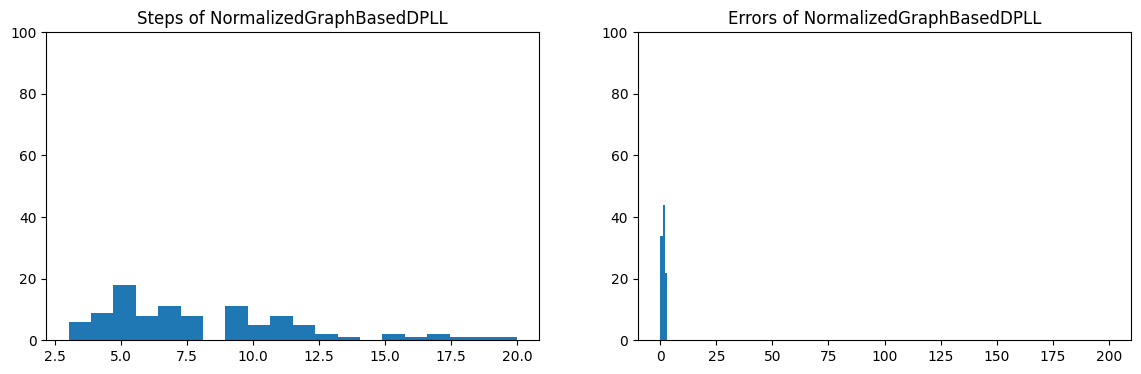

100%|██████████| 100/100 [00:00<00:00, 1347.42it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.16; stdev step: 4.03; avg error: 0.83; stdev error: 0.71


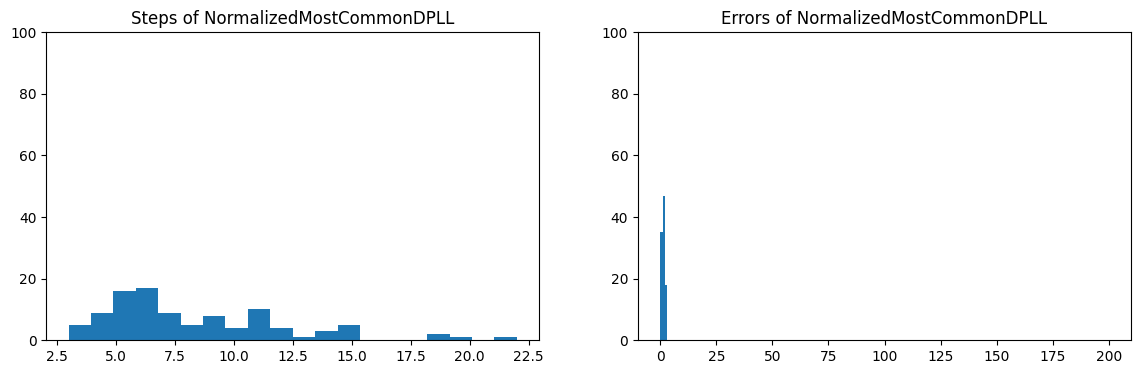

100%|██████████| 100/100 [00:00<00:00, 1454.48it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.31; stdev step: 3.60; avg error: 0.49; stdev error: 0.56


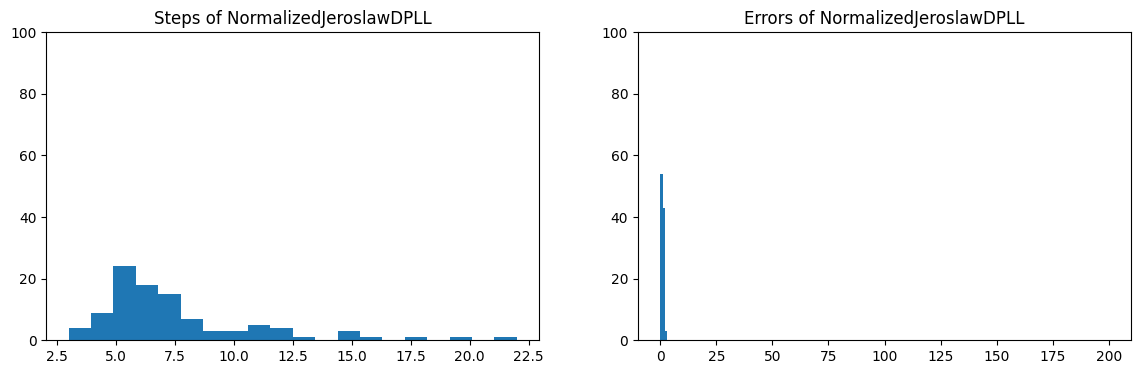

In [15]:
print_all(100, 200, 10)

We have generated 100 formulas


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.45; stdev step: 5.78; avg error: 1.08; stdev error: 0.83


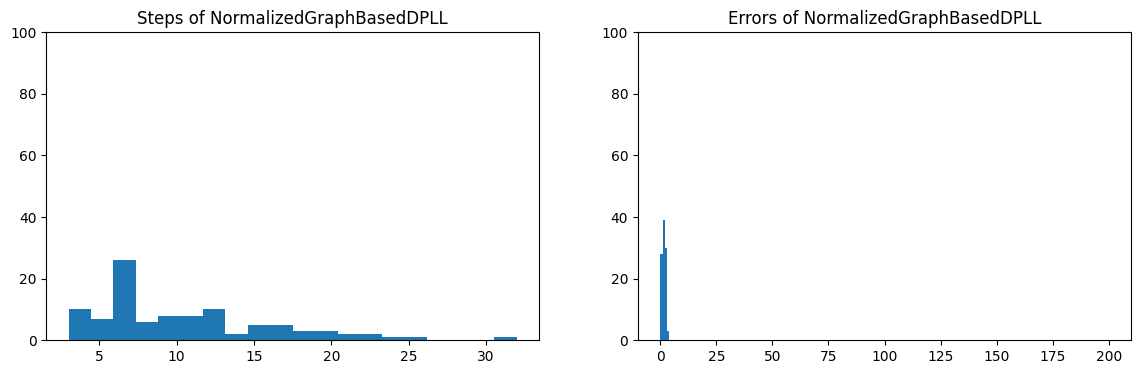

100%|██████████| 100/100 [00:00<00:00, 813.73it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.27; stdev step: 5.75; avg error: 1.09; stdev error: 0.87


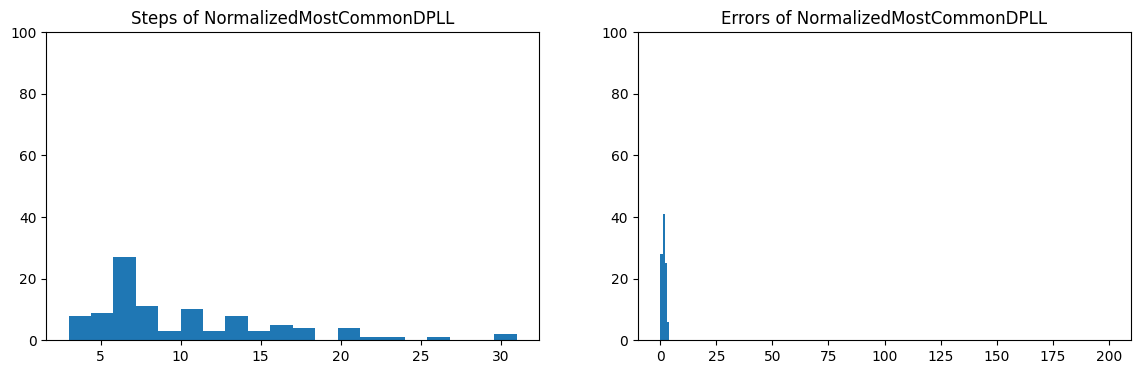

100%|██████████| 100/100 [00:00<00:00, 912.88it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.86; stdev step: 4.90; avg error: 0.65; stdev error: 0.68


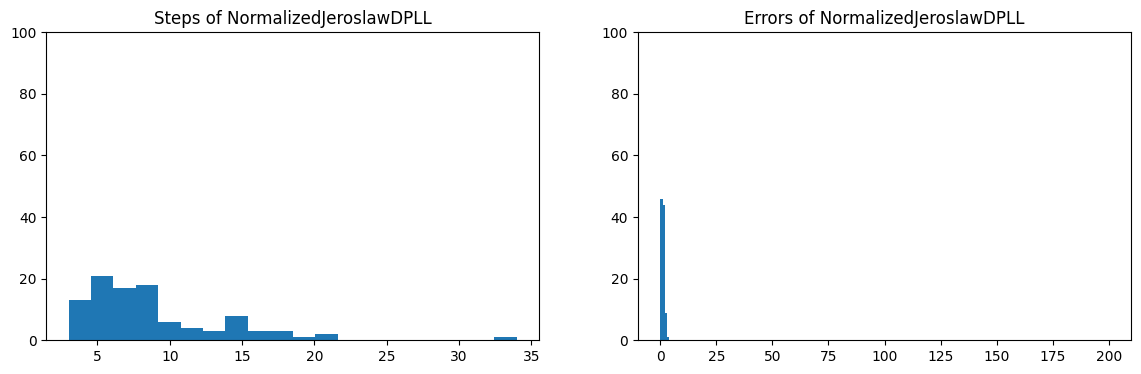

In [16]:
print_all(100, 200, 12)

We have generated 100 formulas


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 12.78; stdev step: 8.30; avg error: 1.22; stdev error: 0.92


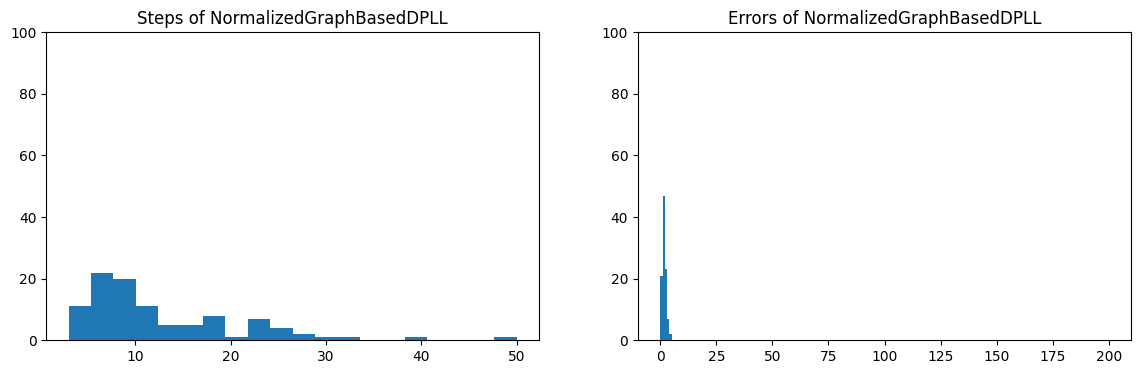

100%|██████████| 100/100 [00:00<00:00, 614.98it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.90; stdev step: 7.81; avg error: 1.13; stdev error: 0.88


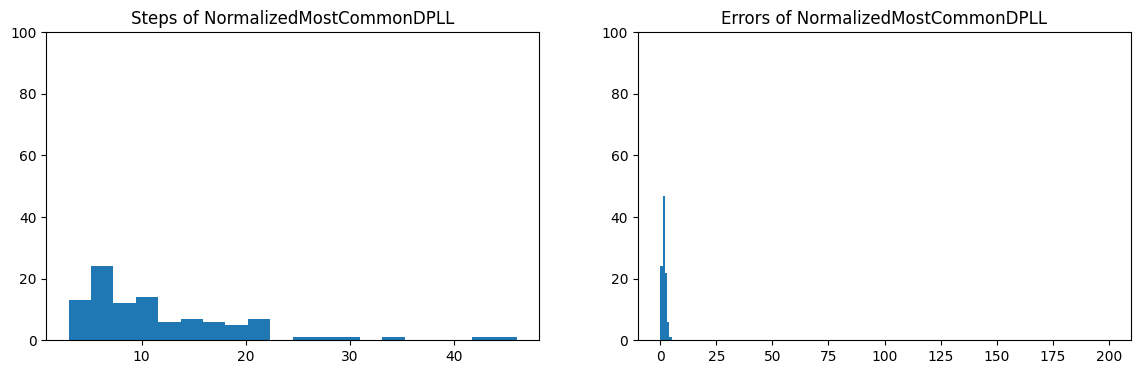

100%|██████████| 100/100 [00:00<00:00, 657.52it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.61; stdev step: 6.12; avg error: 0.80; stdev error: 0.73


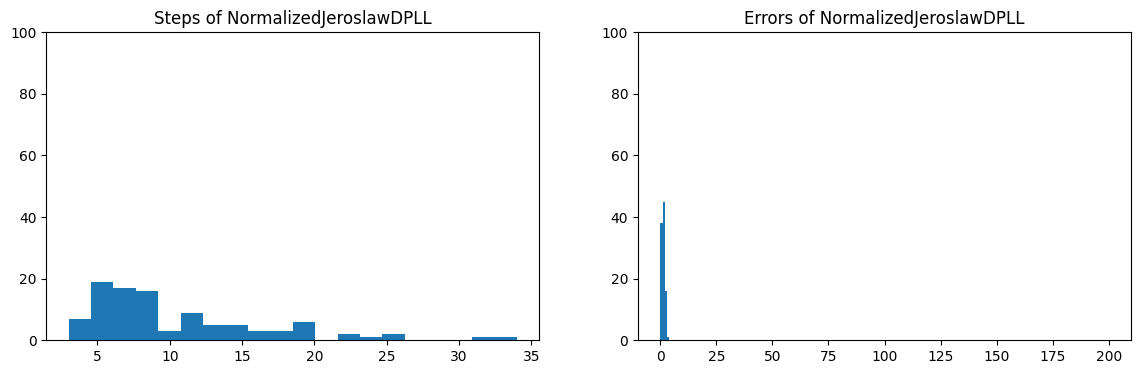

In [17]:
print_all(100, 200, 14)

We have generated 100 formulas


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 16.95; stdev step: 10.62; avg error: 1.46; stdev error: 0.94


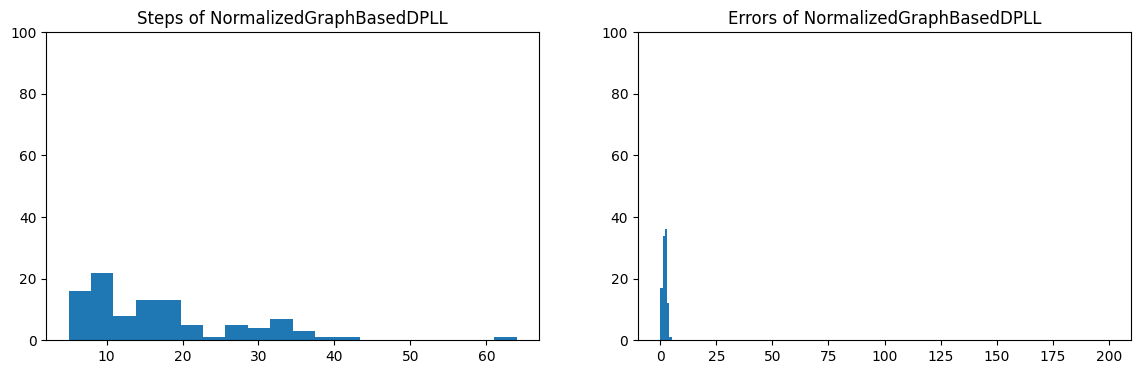

100%|██████████| 100/100 [00:00<00:00, 402.56it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.44; stdev step: 10.14; avg error: 1.33; stdev error: 0.88


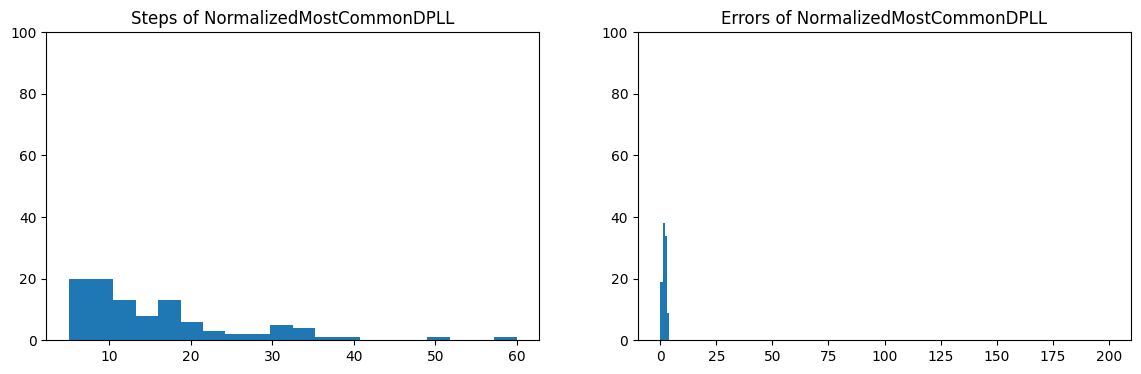

100%|██████████| 100/100 [00:00<00:00, 525.55it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.89; stdev step: 6.72; avg error: 0.89; stdev error: 0.66


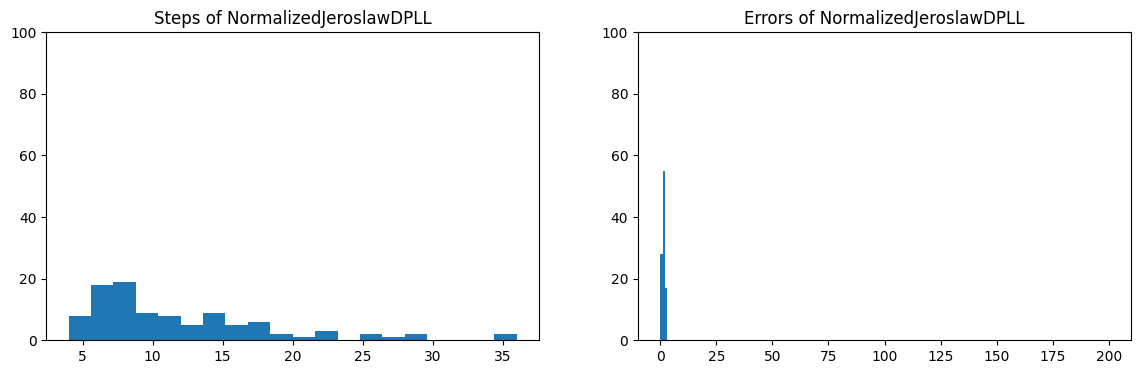

In [18]:
print_all(100, 200, 16)

We have generated 100 formulas


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.24; stdev step: 18.18; avg error: 1.68; stdev error: 1.09


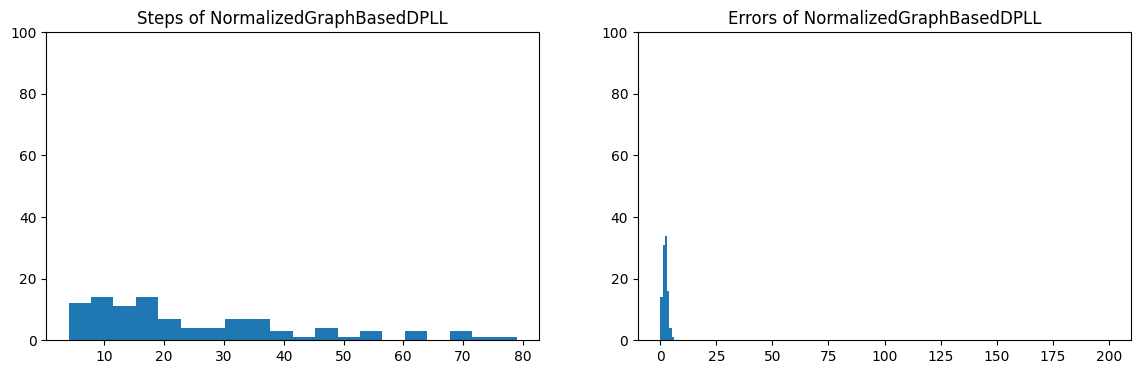

100%|██████████| 100/100 [00:00<00:00, 217.42it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.99; stdev step: 17.41; avg error: 1.60; stdev error: 1.07


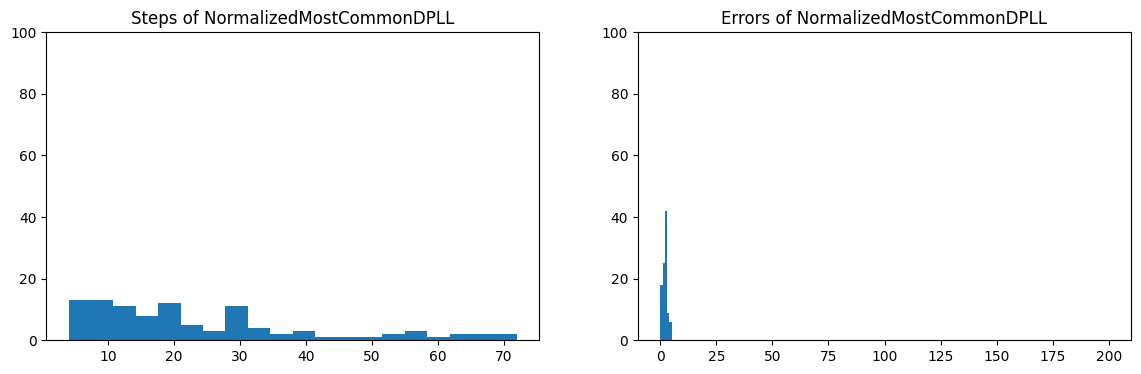

100%|██████████| 100/100 [00:00<00:00, 265.02it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.68; stdev step: 11.47; avg error: 1.14; stdev error: 0.74


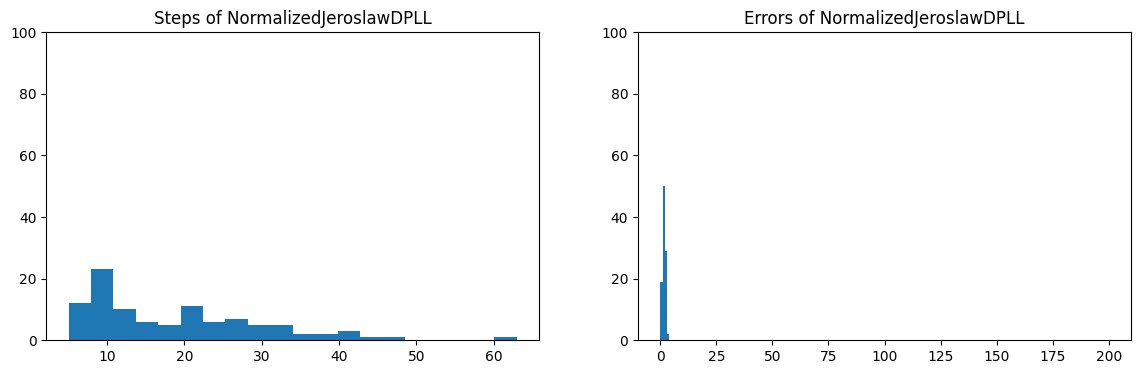

In [19]:
print_all(100, 200, 20)

We have generated 100 formulas


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 35.72; stdev step: 32.76; avg error: 1.70; stdev error: 1.14


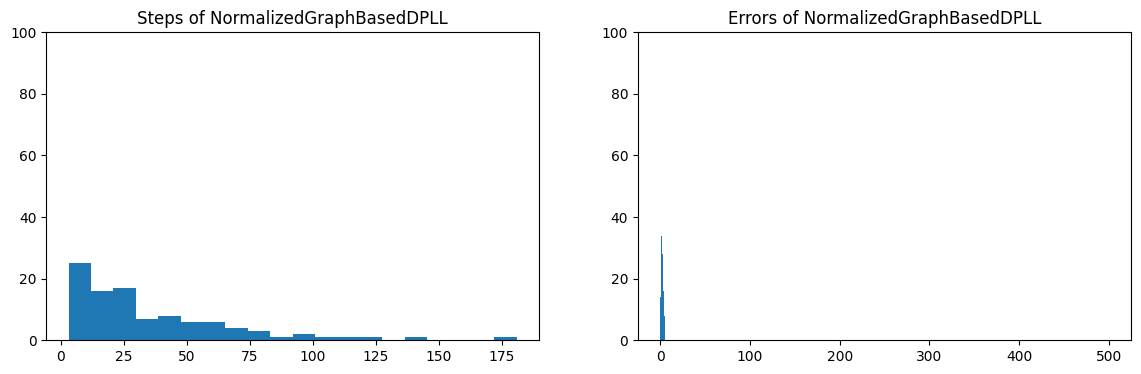

100%|██████████| 100/100 [00:01<00:00, 91.54it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 33.53; stdev step: 31.92; avg error: 1.73; stdev error: 1.14


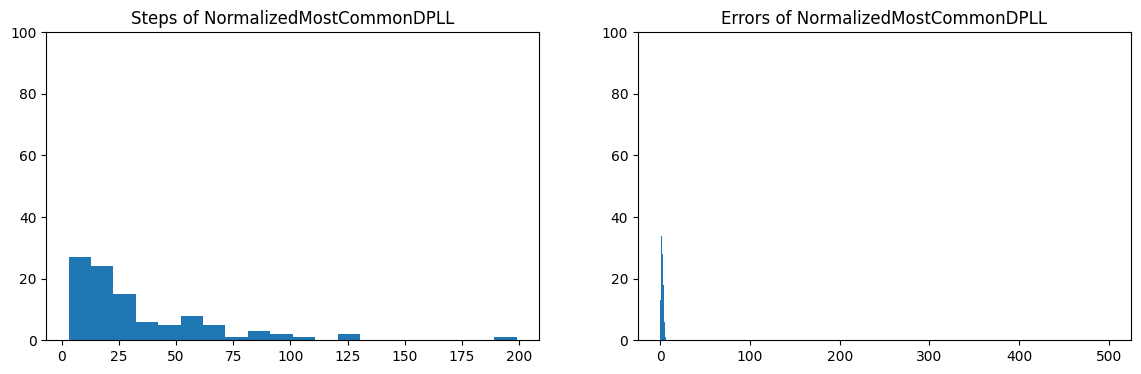

100%|██████████| 100/100 [00:00<00:00, 164.77it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.76; stdev step: 14.53; avg error: 1.05; stdev error: 0.83


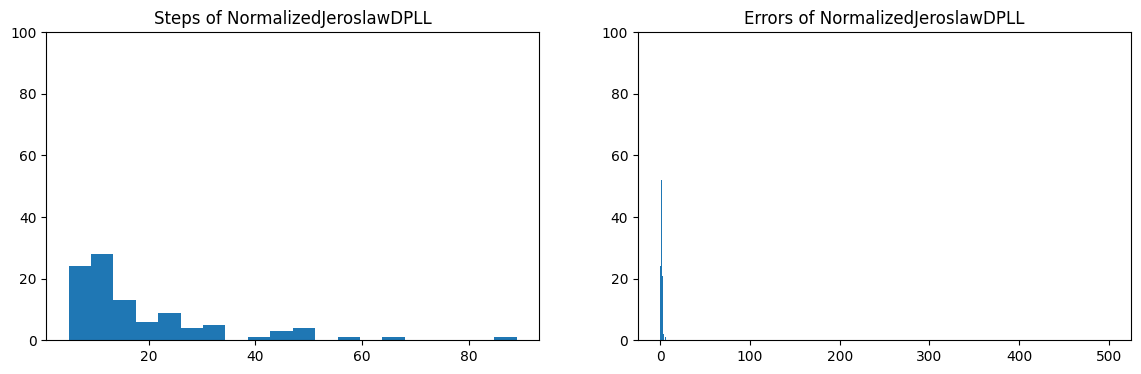

In [20]:
print_all(100, 500, 25, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 60.05; stdev step: 58.28; avg error: 2.12; stdev error: 1.29


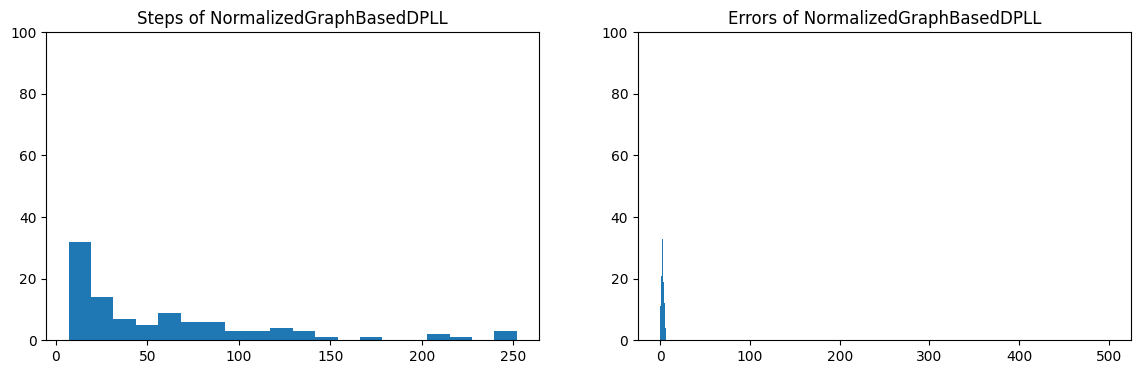

100%|██████████| 100/100 [00:02<00:00, 42.18it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 54.77; stdev step: 49.99; avg error: 2.13; stdev error: 1.21


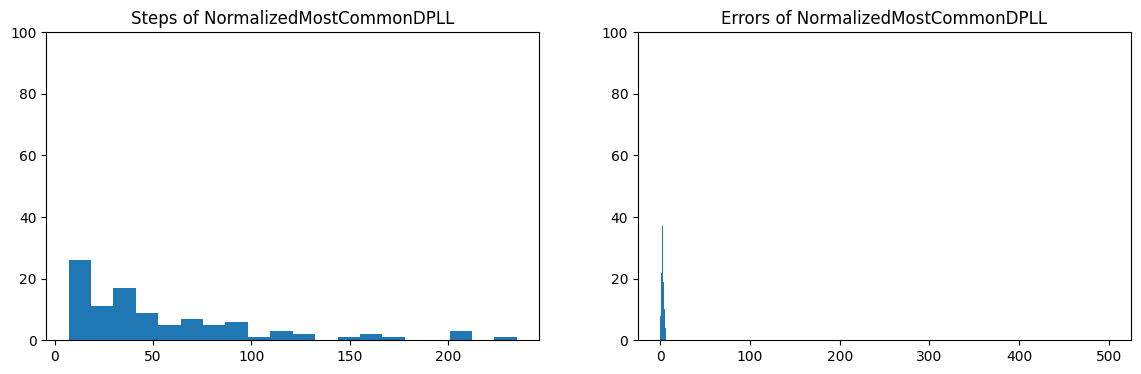

100%|██████████| 100/100 [00:01<00:00, 73.09it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.71; stdev step: 25.86; avg error: 1.23; stdev error: 0.80


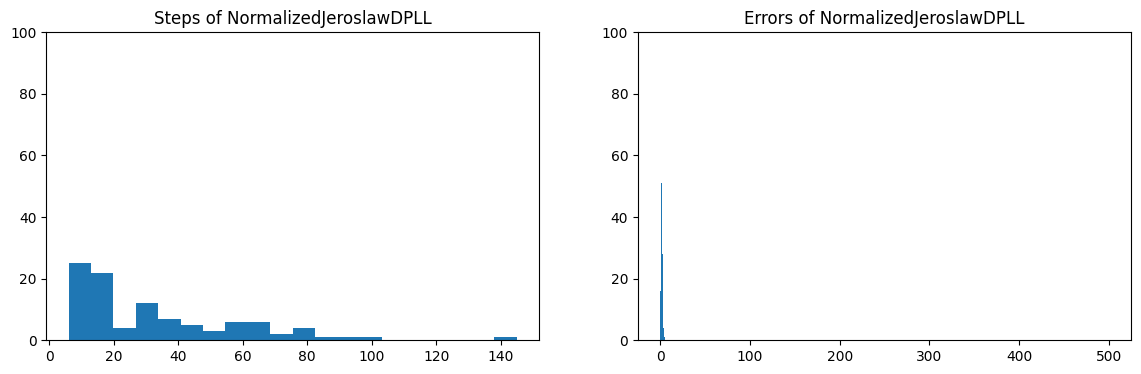

In [21]:
print_all(100, 500, 30, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [10:39<00:00,  6.40s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 207.54; stdev step: 171.09; avg error: 2.88; stdev error: 1.35


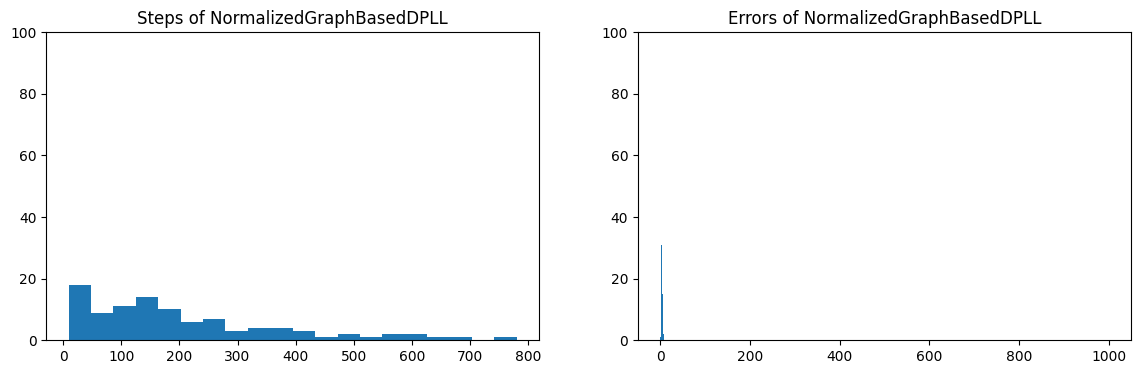

100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 198.68; stdev step: 165.04; avg error: 2.80; stdev error: 1.31


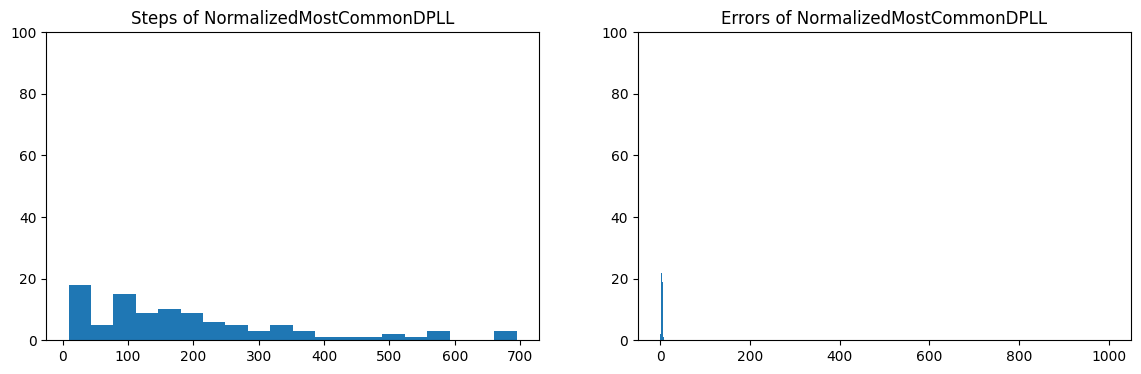

100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 83.80; stdev step: 73.45; avg error: 1.84; stdev error: 1.12


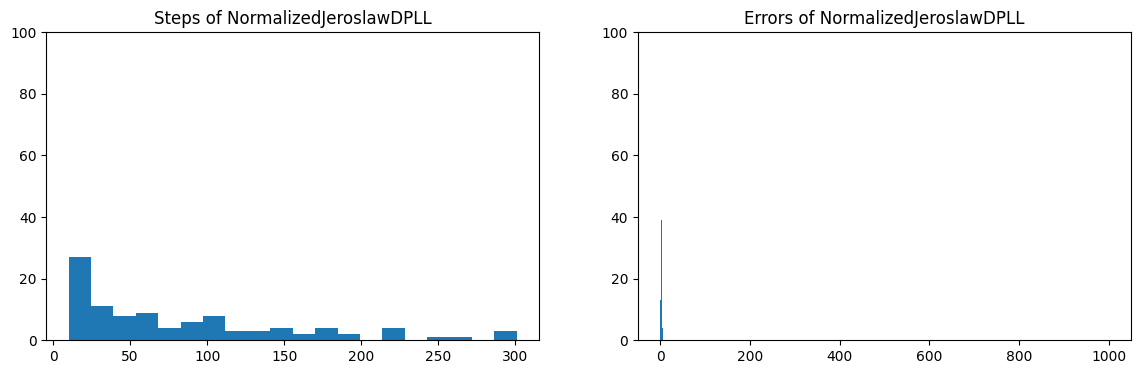

In [22]:
print_all(100, 1000, 40, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [29:05<00:00, 17.45s/it]


Within 1000 steps solved 87 problems out of 100
#Sats: 87; avg step: 397.48; stdev step: 312.54; avg error: 2.94; stdev error: 1.38


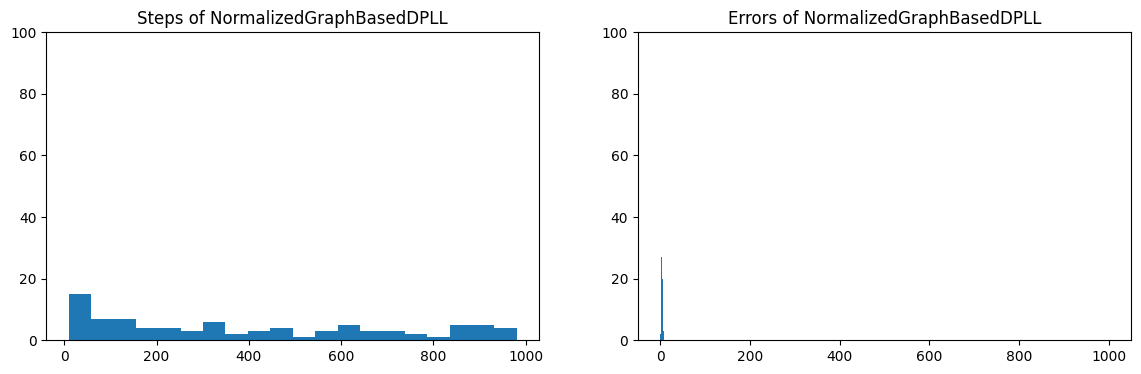

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Within 1000 steps solved 82 problems out of 100
#Sats: 82; avg step: 356.94; stdev step: 268.94; avg error: 2.95; stdev error: 1.32


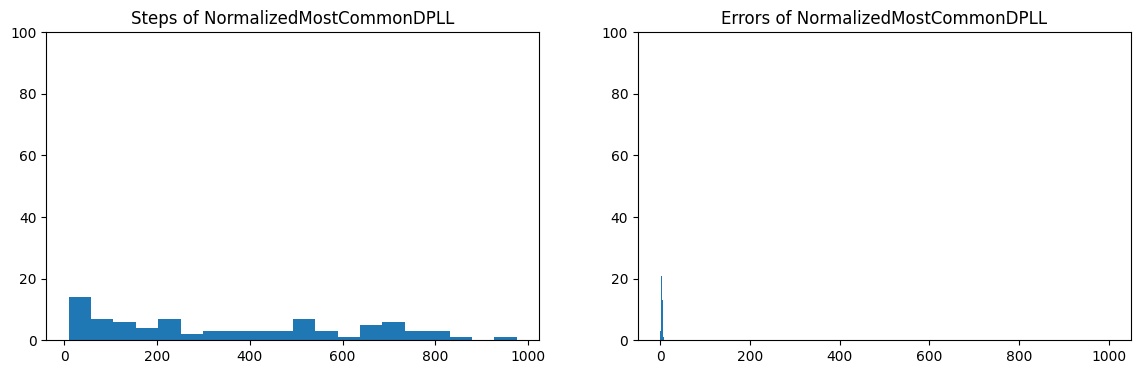

100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 152.69; stdev step: 146.97; avg error: 2.01; stdev error: 1.09


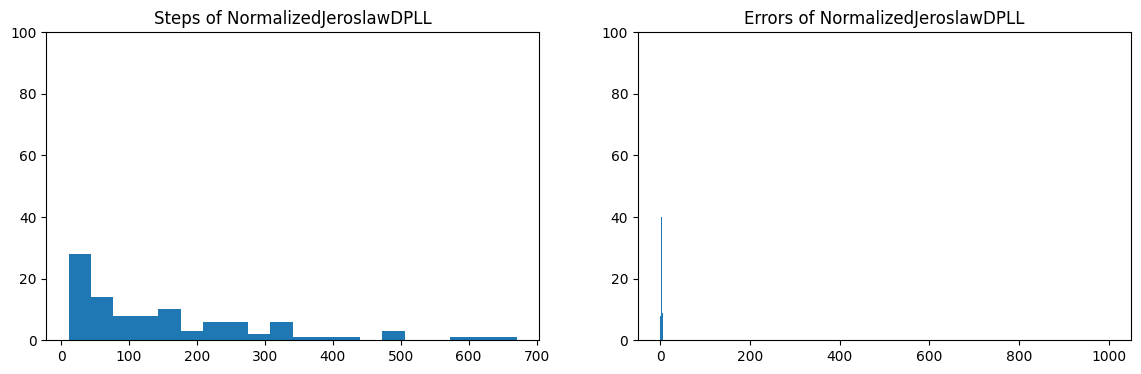

In [23]:
print_all(100, 1000, 50, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [1:05:08<00:00, 39.08s/it]


Within 1000 steps solved 15 problems out of 100
#Sats: 15; avg step: 316.07; stdev step: 266.88; avg error: 3.07; stdev error: 1.29


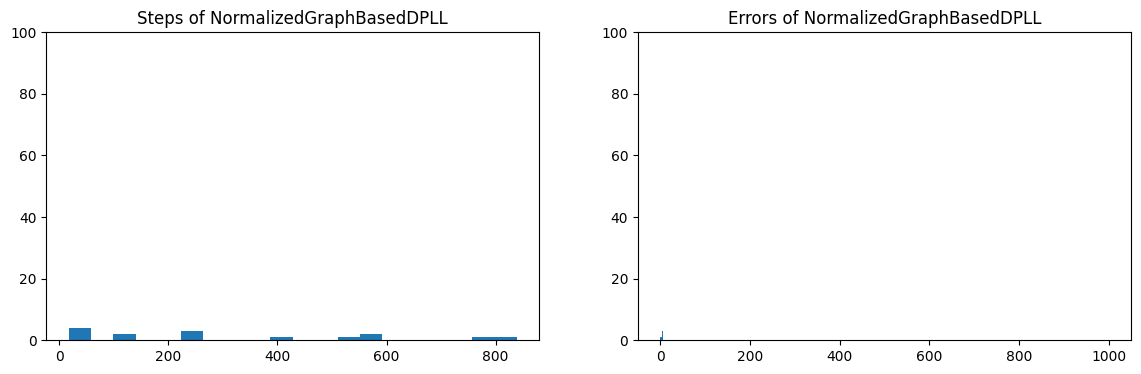

100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Within 1000 steps solved 24 problems out of 100
#Sats: 24; avg step: 370.75; stdev step: 307.04; avg error: 3.58; stdev error: 1.11


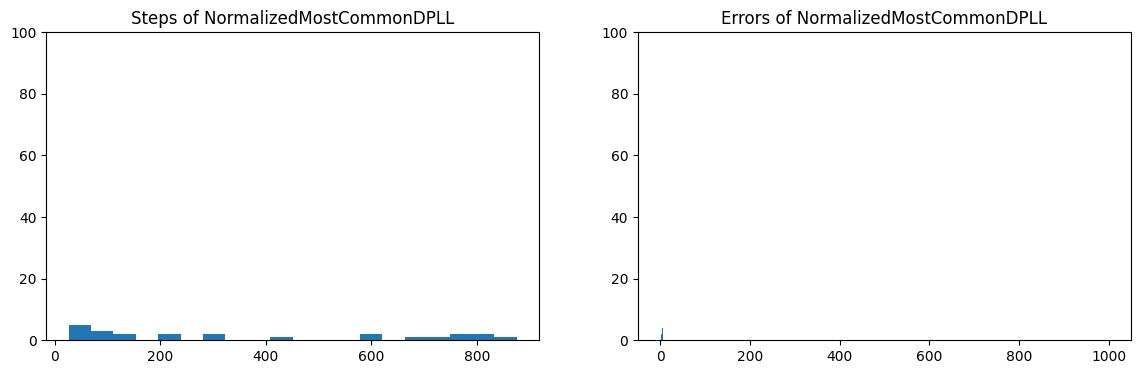

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Within 1000 steps solved 72 problems out of 100
#Sats: 72; avg step: 375.93; stdev step: 282.15; avg error: 2.76; stdev error: 1.16


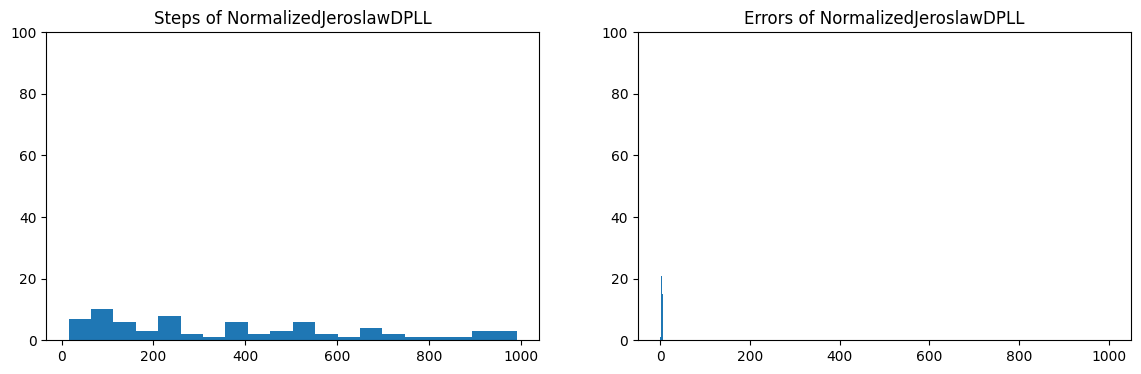

In [24]:
print_all(100, 1000, 70, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [1:19:00<00:00, 47.40s/it]


Within 1000 steps solved 9 problems out of 100
#Sats: 9; avg step: 311.78; stdev step: 218.70; avg error: 4.00; stdev error: 2.00


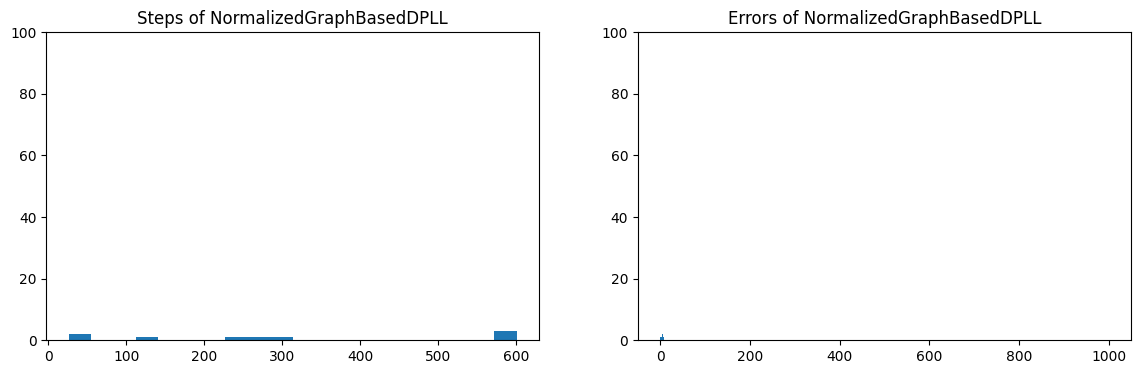

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


Within 1000 steps solved 10 problems out of 100
#Sats: 10; avg step: 418.80; stdev step: 272.65; avg error: 3.90; stdev error: 1.70


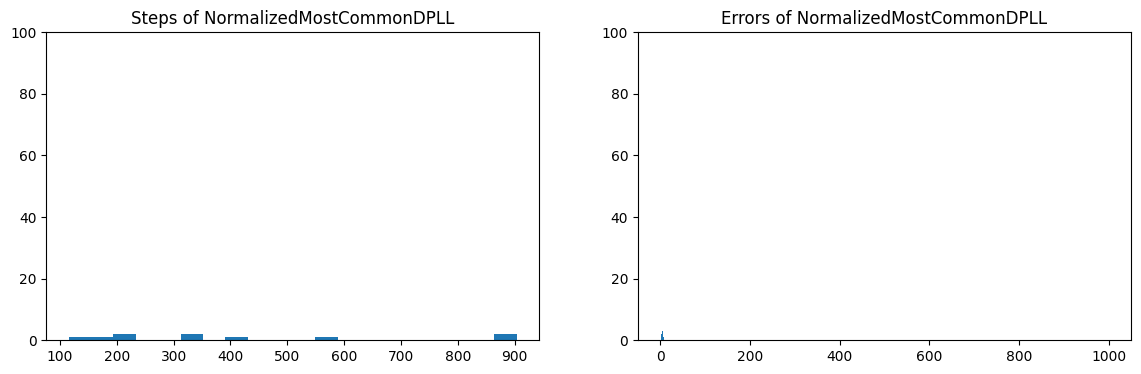

100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Within 1000 steps solved 37 problems out of 100
#Sats: 37; avg step: 356.16; stdev step: 318.20; avg error: 2.35; stdev error: 1.21


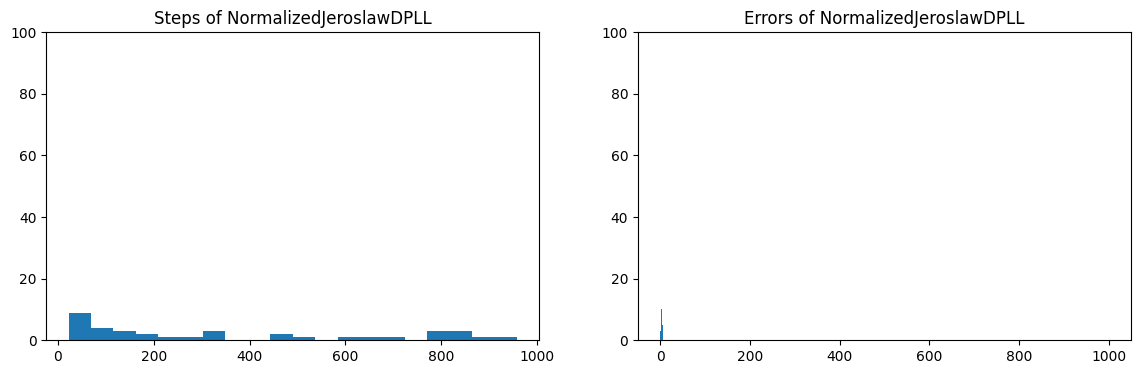

In [26]:
print_all(100, 1000, 90, light=True)

We have generated 100 formulas


100%|██████████| 100/100 [1:35:39<00:00, 57.40s/it]


Within 1000 steps solved 2 problems out of 100
#Sats: 2; avg step: 290.50; stdev step: 269.50; avg error: 2.50; stdev error: 1.50


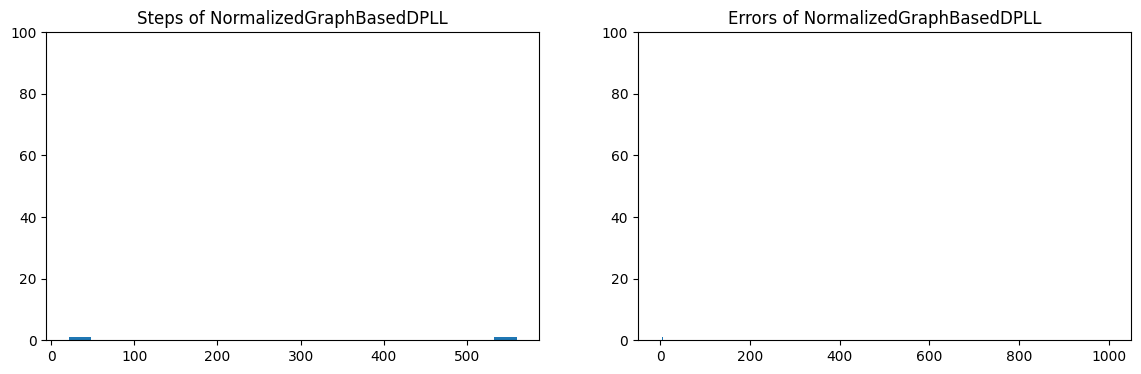

100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


Within 1000 steps solved 1 problems out of 100
#Sats: 1; avg step: 415.00; stdev step: 0.00; avg error: 2.00; stdev error: 0.00


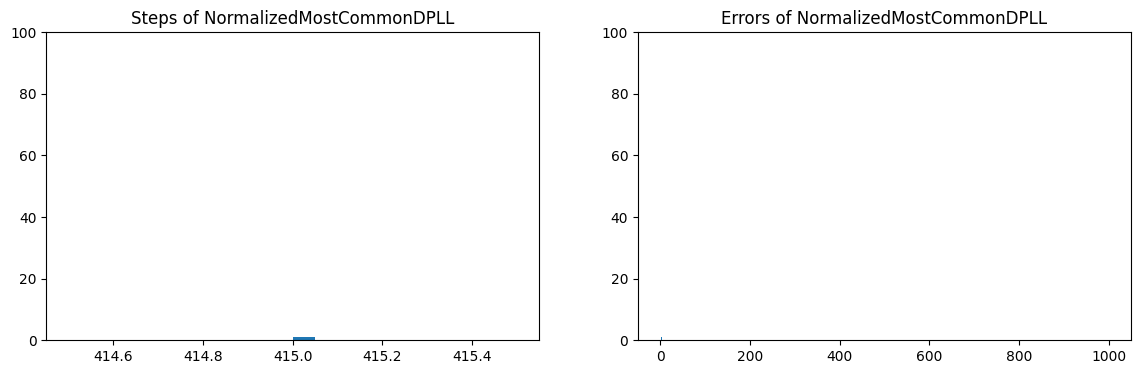

100%|██████████| 100/100 [05:11<00:00,  3.11s/it]


Within 1000 steps solved 11 problems out of 100
#Sats: 11; avg step: 240.73; stdev step: 184.97; avg error: 2.82; stdev error: 0.83


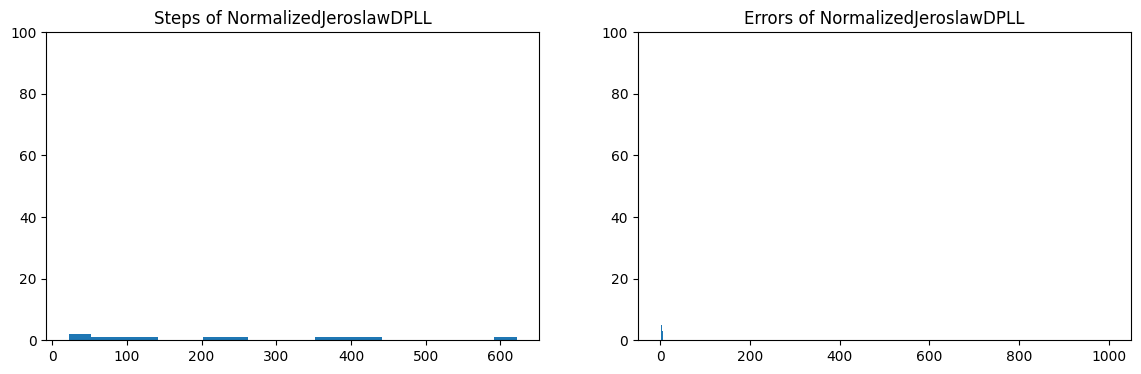

In [27]:
print_all(100, 1000, 110, light=True)